In [1]:
# Install a pip package in the current Jupyter kernel
import subprocess
import sys
subprocess.call([sys.executable,"-m","pip","install","numpy","gspread","oauth2client","df2gspread","pandas","matplotlib","seaborn", "pandas-profiling", "PyGithub"])


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


0

In [141]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from pandas.api.types import is_numeric_dtype, is_string_dtype
import gspread
import seaborn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
from itertools import chain
from oauth2client.service_account import ServiceAccountCredentials
import time
from collections import defaultdict
import github
from github import Github
from github.ContentFile import ContentFile
from pathlib import Path

In [252]:
### Uncomment this only if you need to check the states of multiple PR's
### This will generate subsets of the list to comply with the github api rate limits of around 60 per hour

    # Check API rate limits: 
    #    curl -H "Accept: application/vnd.github+json" \
    #    -H "Authorization: Bearer <TOKEN>" \
    #     https://api.github.com/rate_limit

#prs_list = pd.read_csv("../collected_data/pull_requests_list.csv")

#dataset_size = prs_list.shape[0]
#submissions_per_hour = 29

#start_index = 0
#end_index = submissions_per_hour

#subset_idx = 0
#while end_index < dataset_size:
#    print(f'Saving subset: {subset_idx} from: {start_index} to: {end_index}')
#    subset = prs_list.loc[start_index: end_index]
#    filepath = Path(f'../collected_data/subset_{subset_idx}.csv')
#    subset.to_csv(filepath)
#    start_index = end_index + 1
#    end_index = start_index + submissions_per_hour
#    subset_idx = subset_idx + 1
#
#if start_index < dataset_size:
#    print(f'Saving subset: {subset_idx} from: {start_index} to: {dataset_size}')
#   subset = prs_list.loc[start_index:]
#   filepath = Path(f'../collected_data/subset_{subset_idx}.csv')
#    subset.to_csv(filepath)


In [251]:
### Uncomment this only if you need to check the states of multiple PR's
### This can be used to process the files generated on the previous step and add the PR state on the CSV file

#states = []
#prs_list_sub = pd.read_csv("../collected_data/subset_10a.csv")
#ACCESS_TOKEN = <YOUR ACCOUNT TOKEN HERE>
#filepath = Path('../collected_data/pull_requests_list_with_state_10a.csv')
#gh_instance = Github(ACCESS_TOKEN)

## This is doing two request: one to get the repo and another to get the pull
#sub_sub_list = prs_list_sub['GitHub address'].loc[10:]
#sub_sub_list
#for pr in prs_list_sub['GitHub address']:
#    pull_position = pr.find('pull')
#    addrs_size = len('https://github.com/')
#    pr_number = int(pr[pull_position + 5:])
#    pr_name = pr[addrs_size:pull_position -1]
#    repo = gh_instance.get_repo(pr_name)
#    pull = repo.get_pull(pr_number)
#    raw_data = pull.raw_data
#    state = raw_data['state']
#    if raw_data['merged']:
#        states.append('merged')
#        state = 'merged'
#    else:
#        states.append(state)
#    print(f'Fetched::: Name: {pr_name}, Number: {pr_number}, State: {state}')
#
#prs_list_sub['PR State'] = states
#prs_list_sub.to_csv(filepath)

In [253]:
### Uncomment this only if you need to check the states of multiple PR's
### This will concatenate all the files from the previous steps

#import os
#
#file_paths = os.listdir("../collected_data/")
#all_prs_with_state = pd.DataFrame(columns=['GitHub address', 'PR State'])
#for file_path in file_paths:
#    if 'pull_requests_list_with_state' in file_path:
#        pr_batch = pd.read_csv(f'../collected_data/{file_path}')
#        all_prs_with_state = pd.concat([all_prs_with_state, pr_batch])
#
#filepath = Path('../collected_data/pull_requests_list_with_state.csv')
#all_prs_with_state.to_csv(filepath)

In [268]:
data = pd.read_csv('../collected_data/pull_requests_list_with_state.csv')

In [283]:
# Get all states

states_count = defaultdict(list[int])
available_states = []
for state in data['PR State']:
    if state not in available_states:
        available_states.append(state)
    states_count[state].append(1)

for state in available_states:
    states_count[state] = sum(states_count[state])
    
states_count

defaultdict(list[int], {'open': 197, 'closed': 116, 'merged': 65})

In [315]:
def draw_pie_chart(labels, sizes, explode, path):
    size = 0.4
    dims = (11.7, 8.27)
    fig1, ax1 = plt.subplots(figsize=dims)
    cmap = plt.get_cmap("tab20c")
    colors = cmap(np.arange(3)*4)
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors, textprops={'size': 'large', 'weight': 'bold'},
            wedgeprops=dict(width=size, edgecolor='w'), pctdistance=0.8)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.savefig(path, format='pdf', bbox_inches='tight')
    plt.show()

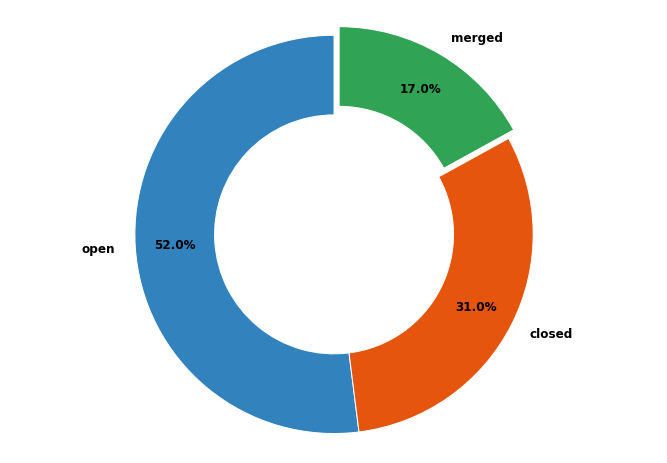

In [316]:
answers_size = data.shape[0]
states_distribution = {key: round(value / answers_size, 2) for key, value in states_count.items()}

labels = list(states_distribution.keys()) 
sizes = list(states_distribution.values())

explode = (0, 0, 0.05) # choose which slice to explode

filepath = Path('../figures/pr-states-distribution.pdf')
draw_pie_chart(labels, sizes, explode, filepath)